In [1]:
from grad_cam.cam import clip_grad_cam
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
import torch

from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection,attn2map
from ithor_tools.map import single_scenemap

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_gradcam = clip_grad_cam(device)

/home/kkiruk/.pyenv/versions/3.8.8/envs/ai2thor/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [3]:
gridSize=0.05
scene_name = "FloorPlan_Train8_1"
controller = Controller(
    agentMode="locobot",
    visibilityDistance=5.0,
    scene = scene_name,
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderClassImage = True,
    renderDepthImage=True,
    renderInstanceSegmentation=False,
    width=300,
    height=300,
    fieldOfView=60
)

INFO - 2022-06-01 23:22:49,227 - controller - Initialize return: {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}


In [4]:
controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderClassImage = True,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)
scene_bounds = controller.last_event.metadata['sceneBounds']['center']

controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=5.0, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize= 5.0, fieldOfView=100,
    skyboxColor="white"
)
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']

controller.step(
    action="Teleport",
    position = rstate[200],
    rotation = dict(x=0,y=0,z=0)
)



<ai2thor.server.Event at 0x7f395aff6610
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [5]:
objects = controller.last_event.metadata['objects']
df = show_objects_table(objects)
df

Object Metadata. Not showing objectOrientedBoundingBox, axisAlignedBoundingBox, and receptacleObjectIds for clarity.


,objectType,objectId,name,position[x],position[y],position[z],rotation[x],rotation[y],rotation[z],distance,...,openness,pickupable,isPickedUp,moveable,mass,salientMaterials,assetId,parentReceptacles,controlledObjects,isMoving
0,Plate,Plate|+01.86|+00.73|-01.18,Plate_26,1.8645,0.7321,-1.1818,359.8788,16.2492,359.9527,3.6444,...,0.0,True,False,False,0.62,[Ceramic],Plate_26,[SideTable|+01.59|+00.00|-01.17],None,False
1,Bottle,Bottle|+05.66|+00.54|-02.50,Bottle_1,5.6640,0.5446,-2.4960,359.9635,359.9903,359.9713,3.6314,...,0.0,True,False,False,0.20,[Glass],Bottle_1,[CoffeeTable|+05.45|+00.00|-02.95],None,False
2,HousePlant,HousePlant|+05.42|+00.55|-02.95,Houseplant_6,5.4193,0.5468,-2.9490,0.0490,0.0522,359.8313,3.1705,...,0.0,False,False,True,3.00,"[Ceramic, Organic]",Houseplant_6,[CoffeeTable|+05.45|+00.00|-02.95],None,False
3,Apple,Apple|+05.38|+00.61|-03.39,Apple_6,5.3818,0.6092,-3.3868,310.4292,307.2209,267.1528,2.9112,...,0.0,True,False,False,0.20,[Food],Apple_6,[CoffeeTable|+05.45|+00.00|-02.95],None,False
4,Bowl,Bowl|+05.66|+00.54|-03.35,Bowl_6,5.6636,0.5450,-3.3521,0.0019,359.9756,0.0093,3.1850,...,0.0,True,False,False,0.47,[Ceramic],Bowl_6,[CoffeeTable|+05.45|+00.00|-02.95],None,False
5,BasketBall,BasketBall|+07.12|+00.17|-01.90,Basketball_1,7.1227,0.1660,-1.9024,7.9563,286.2621,91.9585,5.2012,...,0.0,True,False,False,0.60,[Rubber],Basketball_1,"[ShelvingUnit|+07.10|+00.00|-01.96, Floor|+00....",None,False
6,AlarmClock,AlarmClock|+01.31|+00.48|-04.01,Alarm_Clock_6,1.3060,0.4778,-4.0129,0.0043,74.9883,0.0133,1.6980,...,0.0,True,False,False,0.80,"[Metal, Plastic, Glass]",Alarm_Clock_6,"[SideTable|+01.21|+00.00|-04.25, Floor|+00.00|...",None,False
7,Television,Television|+09.53|+00.96|-03.10,Television_6,9.5309,0.9628,-3.1030,0.1047,269.9915,0.0799,6.9180,...,0.0,False,False,True,9.83,"[Plastic, Metal]",Television_6,"[SideTable|+09.60|+00.00|-03.08, Floor|+00.00|...",[],False
8,RemoteControl,RemoteControl|+01.15|+00.48|-04.24,Remote_3,1.1509,0.4773,-4.2404,0.0190,345.4326,359.9791,1.7636,...,0.0,True,False,False,0.15,"[Metal, Plastic]",Remote_3,"[SideTable|+01.21|+00.00|-04.25, Floor|+00.00|...",None,False
9,TennisRacket,TennisRacket|+03.73|+00.50|-02.84,Tennis_Racket_3,3.7317,0.4986,-2.8410,88.3605,178.1059,164.4330,2.1180,...,0.0,True,False,False,0.31,"[Metal, Plastic]",Tennis_Racquet_3,"[CoffeeTable|+03.44|00.00|-02.69, Floor|+00.00...",None,False


In [6]:
query_object = objects[6]
controller.step(
    action="Teleport",
    position = rstate[200],
    rotation = dict(x=0,y=270,z=0)
)
print(len(rstate))

7243


0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789
(98, 59)
(418, 713, 3)


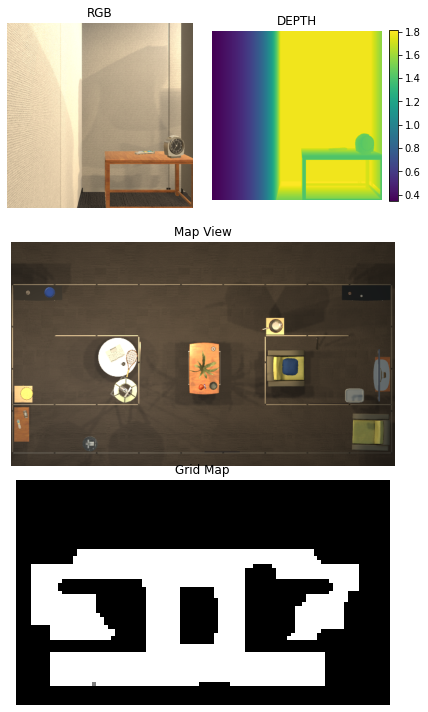

In [7]:
scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)
sm = single_scenemap(scene_bounds,rstate,stepsize = 0.1)

pos = controller.last_event.metadata['agent']['position']
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)

# proj = attn2map(sm.gridmap)

/home/kkiruk/.pyenv/versions/3.8.8/envs/ai2thor/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.Size([1, 1, 800, 800])


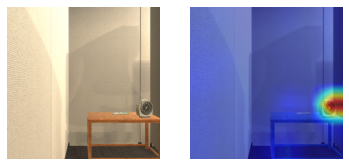

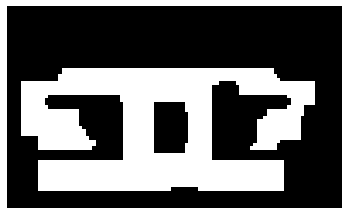

In [9]:
text = 'remote control'
img= controller.last_event.frame
clip_gradcam.set_text(text)
attn,norm_attn = clip_gradcam.run(img)

proj.reset()
proj.transform(attn,controller,sm)

In [104]:
import numpy as np
import math

import open3d as o3d
import matplotlib.pyplot as plt
from skimage.transform import resize
import copy

def cornerpoint_projection(cornerpoints):
    res = []
    for e,c in enumerate(cornerpoints):
        if e%4==0 or e%4==1:
            res.append([c[0],c[2]])
    return res

def to_rad(th):
    return th*math.pi / 180

def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

class attn2map():
    def __init__(self,metric_map):
        self.metric_map = copy.deepcopy(metric_map)
        self.new_map = 1- np.expand_dims(copy.deepcopy(metric_map),axis=-1)
        self.new_map = np.repeat(self.new_map,3,axis=-1)
        width = 800
        height = 800
        fov = 60
        self.width = width
        self.height = height
        # camera intrinsics
        focal_length = 0.5 * width / math.tan(to_rad(fov/2))
        fx, fy, cx, cy = (focal_length,focal_length, width/2, height/2)
        self.intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, 
                                fx, fy, cx, cy)
                                
    def get_projection(self,controller,attn,agent_pos,rot):
        DEPTH = controller.last_event.depth_frame
        COLOR = controller.last_event.frame

        attn = 20*attn.astype(np.float32)
        attn = np.clip(attn,0,1)

        depth = o3d.geometry.Image(DEPTH)
        color = o3d.geometry.Image(attn)
        rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth,
                                                                    depth_scale=1.0,
                                                                    depth_trunc=5.0,
                                                                    convert_rgb_to_intensity=False)
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, self.intrinsic)
        pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
        
        rot = math.pi*rot/180
        pcd.transform([[-math.sin(rot), 0,-math.cos(rot), agent_pos['z']],
                [0, 1, 0, agent_pos['y']],
                [math.cos(rot), 0, -math.sin(rot), agent_pos['x']],
                [0, 0, 0, 1]])

        
        voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
                                                                    voxel_size=0.1)
        # print('voxelization')
        # o3d.visualization.draw_geometries([voxel_grid])
        voxels = voxel_grid.get_voxels()  # returns list of voxels
        indices = np.stack(list(vx.grid_index for vx in voxels))
        shape = indices.max(axis=0)
        res = np.zeros((shape[2]+1,shape[0]+1))
        vpos= []
        for vx in voxels:
            grid_index = vx.grid_index
            pos_temp = voxel_grid.get_voxel_center_coordinate(grid_index)
            color = vx.color[0]
            temp = res[grid_index[2],grid_index[0]]
            if color>temp and color>0.75:
                # print(color)
                res[grid_index[2],grid_index[0]] = color
                vpos.append(dict(pos=pos_temp,color = color))
        del pcd, voxel_grid
        return res,vpos

    def flip(self,res,rot):
        if rot == 270:
            return np.flip(res,axis=0)

    def transform(self,attn,controller,scenemap):
        agent_pos = controller.last_event.metadata['agent']['position']
        agent_rot = controller.last_event.metadata['agent']['rotation']['y']
        res,vpos = self.get_projection(controller,attn,agent_pos,agent_rot)
        for voxel in vpos:
            pos = voxel['pos']
            pos = dict(x=pos[2],y=pos[1],z=pos[0])
            pos = scenemap.xyz2grid(pos)

            self.new_map[pos[0],pos[1],2] = voxel['color']
        
        new_map = copy.deepcopy(self.new_map)
        new_map = np.rot90(new_map)

        plt.figure()
        plt.imshow(new_map)
        plt.axis("off")
        plt.show()
        del new_map
    
    def reset(self):
        self.new_map = 1- np.expand_dims(copy.deepcopy(self.metric_map),axis=-1)
        self.new_map = np.repeat(self.new_map,3,axis=-1)
        
proj = attn2map(sm.gridmap)
text = 'pepper shaker'
img= controller.last_event.frame
clip_gradcam.set_text(text)


In [ ]:
controller.step(
    action="Teleport",
    position = rstate[6201],
    rotation = dict(x=0,y=90,z=0)
)
proj.reset()
pos = controller.last_event.metadata['agent']['position']
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)

img= controller.last_event.frame
attn,_ = clip_gradcam.run(img)

proj.transform(attn,controller,sm)